# Baseline **LSTM** Frame Predictor

A companion to the Transformer notebook — shares the same dataset loading,
section layout, and training loop so you can compare apples‑to‑apples.

<small>*(Sections are numbered & boxed exactly like the Transformer notebook.)*</small>

In [1]:
# ╔════════════════════════════╗
# ║ 0. Environment – GPU check ║
# ╚════════════════════════════╝
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ {len(gpus)} GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("⚠️ No GPU found. Training will be slow.")


⚠️ No GPU found. Training will be slow.


In [3]:
# ╔═════════════════════════════════╗
# ║ 1. Load train/val/test datasets ║
# ╚═════════════════════════════════╝
DATA_PATH = "../processed_data/transformer_dataset/"

full_ds = tf.data.Dataset.load(DATA_PATH)

def filter_split(split_id):
    return full_ds.filter(lambda meta, x, y: meta[2] == split_id)

train_ds = filter_split(0).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds   = filter_split(1).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds  = filter_split(2).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)

print("✅ Datasets loaded and batched.")


✅ Datasets loaded and batched.


In [4]:
# ╔══════════════════════╗
# ║ 2. Build LSTM Model ║
# ╚══════════════════════╝
from tensorflow.keras import layers, models

MAX_SEQ_LEN   = 100
NUM_ENTITIES  = 23
INPUT_DIM     = NUM_ENTITIES * 2   # x and y only → 46

inputs = tf.keras.Input(shape=(MAX_SEQ_LEN, INPUT_DIM))  # (batch, 100, 46)

x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(128, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(INPUT_DIM)(x)  # predict next frame (46 values)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100, 46)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 100, 46)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 100)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 256)  │    310,272 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 256)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    197,120 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 46)        │      5,934 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,326 (1.96 MB)

 Trainable params: 513,326 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ╔══════════════════════╗
# ║ 3. Compile Model    ║
# ╚══════════════════════╝
import tensorflow.keras.backend as K

def euclidean_distance_loss(y_true, y_pred):
    # per-sample euclidean distance, then mean over batch
    sq_diff = K.square(y_pred - y_true)         # (batch,46)
    sum_sq  = K.sum(sq_diff, axis=-1)           # (batch,)
    dist    = K.sqrt(sum_sq + 1e-6)             # add epsilon for numerical stability
    return K.mean(dist)                         # scalar

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=euclidean_distance_loss,
    metrics=["mae"]
)


In [6]:
# ╔════════════════════════════════════════╗
# ║ 4. Set up callbacks (EarlyStopping etc) ║
# ╚════════════════════════════════════════╝
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath="saved_models/lstm_position_only_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [11]:
# ╔═══════════════════════════════════════════╗
# ║ 5. Train the model (with timing & callbacks) ║
# ╚═══════════════════════════════════════════╝

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)


Epoch 1/10
   3040/Unknown 1921s 632ms/step - loss: 0.3356 - mae: 0.0394
Epoch 1: val_loss improved from 0.23262 to 0.22544, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 1999s 658ms/step - loss: 0.3356 - mae: 0.0394 - val_loss: 0.2254 - val_mae: 0.0259
Epoch 2/10
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.3255 - mae: 0.0383
Epoch 2: val_loss did not improve from 0.22544
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 1263s 416ms/step - loss: 0.3255 - mae: 0.0383 - val_loss: 0.2395 - val_mae: 0.0281
Epoch 3/10
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3215 - mae: 0.0379
Epoch 3: val_loss improved from 0.22544 to 0.22347, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 4577s 1s/step - loss: 0.3215 - mae: 0.0379 - val_loss: 0.2235 - val_mae: 0.0258
Epoch 4/10


2025-04-30 01:28:58.782609: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.3169 - mae: 0.0373
Epoch 4: val_loss improved from 0.22347 to 0.20816, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 1223s 402ms/step - loss: 0.3169 - mae: 0.0373 - val_loss: 0.2082 - val_mae: 0.0235
Epoch 5/10
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.3130 - mae: 0.0369
Epoch 5: val_loss did not improve from 0.20816
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 2185s 719ms/step - loss: 0.3130 - mae: 0.0369 - val_loss: 0.2092 - val_mae: 0.0240
Epoch 6/10
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3095 - mae: 0.0365
Epoch 6: val_loss did not improve from 0.20816
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 3200s 1s/step - loss: 0.3095 - mae: 0.0365 - val_loss: 0.2127 - val_mae: 0.0248
Epoch 7/10
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.3076 - mae: 0.0363
Epoch 7: val_loss improved from 0.20816 to 0.19708, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━

In [12]:
# ╔═════════════════════╗
# ║ 6. Save final model ║
# ╚═════════════════════╝
model.save("saved_models/lstm_position_only_final.keras")
print("✅ Final model saved!")


✅ Final model saved!


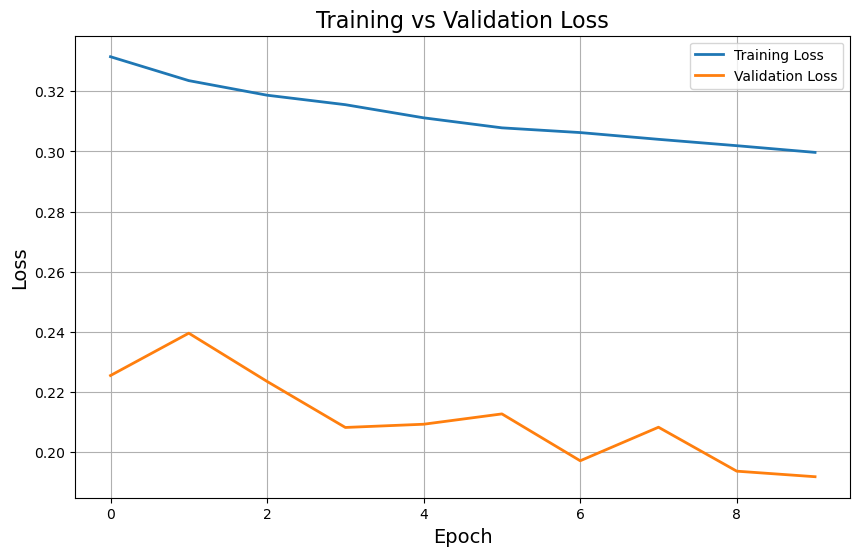

In [13]:
# ╔════════════════════════════════════════╗
# ║ 7. Plot training and validation curves ║
# ╚════════════════════════════════════════╝

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
